In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy

# Import libraries
import os
import random
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
# Download datasets using kagglehub
real_face_dataset = kagglehub.dataset_download("arnaud58/flickrfaceshq-dataset-ffhq")
fake_face_dataset = kagglehub.dataset_download("shavaizbutt/ai-face-dataset-3000-images")

# Define dataset paths
real_dataset_path = real_face_dataset
fake_dataset_path = fake_face_dataset

100%|██████████| 19.5G/19.5G [03:28<00:00, 100MB/s]

Extracting files...


100%|██████████| 3.70G/3.70G [00:27<00:00, 144MB/s]

Extracting files...


Total real images found: 52001
Total fake images found: 3000


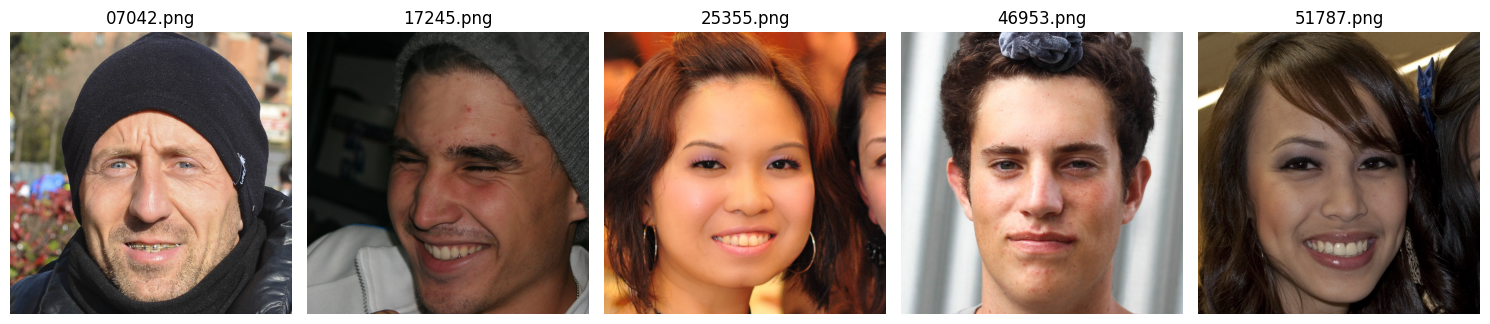

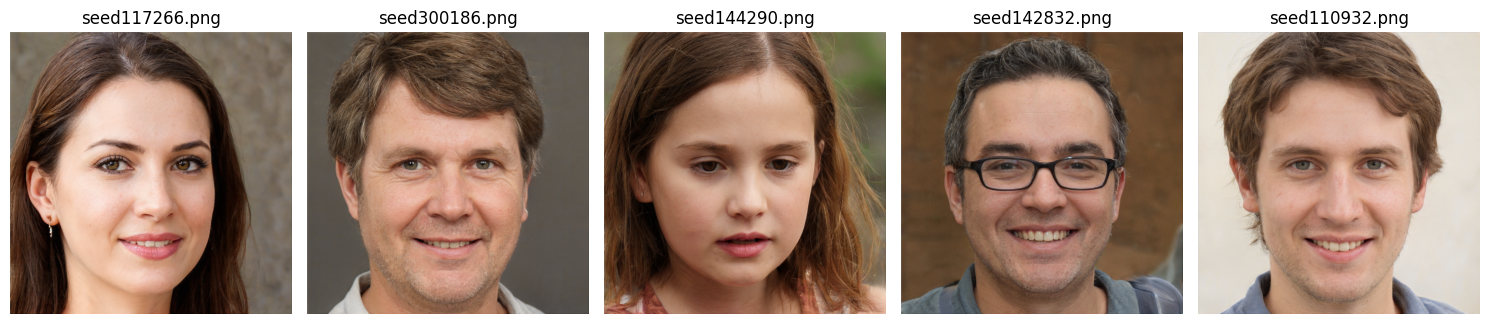

In [8]:
# List all .png images in the dataset folders
real_images = [os.path.join(real_dataset_path, f) for f in os.listdir(real_dataset_path) if f.endswith('.png')]
fake_images = [os.path.join(fake_dataset_path, f) for f in os.listdir(fake_dataset_path) if f.endswith('.png')]

# Safety checks
print(f"Total real images found: {len(real_images)}")
print(f"Total fake images found: {len(fake_images)}")

# Display 5 random real images
sample_real_images = random.sample(real_images, min(5, len(real_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_real_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

# Display 5 random fake images
sample_fake_images = random.sample(fake_images, min(5, len(fake_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_fake_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

In [14]:
# Balance the dataset by selecting 3,000 real images
num_real_images = 3000
if len(real_images) < num_real_images:
    print(f"Warning: Only {len(real_images)} real images available, using all of them.")
    selected_real_images = real_images
else:
    selected_real_images = random.sample(real_images, num_real_images)

# Verify fake images count (should be 3,000 based on dataset description)
if len(fake_images) != num_real_images:
    print(f"Warning: Fake images count ({len(fake_images)}) does not match target ({num_real_images}).")

# Define custom dataset for real and fake images
class DeepfakeDataset(Dataset):
    def __init__(self, real_images, fake_images, transform=None):
        self.real_images = real_images
        self.fake_images = fake_images
        self.transform = transform
        # Create image list and labels (0 for real, 1 for fake)
        self.all_images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)
        # List to store indices of valid images
        self.valid_indices = []
        self.corrupted_files = []

        # Check for valid images during initialization
        for idx in range(len(self.all_images)):
            try:
                img_path = self.all_images[idx]
                image = Image.open(img_path).convert('RGB')
                image.close()  # Close the image to free memory
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.all_images)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files ({len(self.corrupted_files)}): {self.corrupted_files}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map to valid index
        valid_idx = self.valid_indices[idx]
        img_path = self.all_images[valid_idx]
        label = self.labels[valid_idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # This should not happen due to pre-checking, but included as a safeguard
            print(f"Error loading image {img_path}: {e}")
            return None, None

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset with balanced real images
dataset = DeepfakeDataset(selected_real_images, fake_images, transform=transform)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders with custom collate function to handle None values
def custom_collate(batch):
    # Filter out None items
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

Total images: 6000
Valid images: 5997
Corrupted files (3): [('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111370.png', 'unrecognized data stream contents when reading image file'), ('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111695.png', 'broken data stream when reading image file'), ('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111380.png', 'unrecognized data stream contents when reading image file')]


In [15]:
# Define the ResNet-based classifier
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)
        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.1091, Val Loss: 0.0317
Epoch [2/10], Train Loss: 0.0223, Val Loss: 0.0222
Epoch [3/10], Train Loss: 0.0151, Val Loss: 0.0460
Epoch [4/10], Train Loss: 0.0469, Val Loss: 0.0549
Epoch [5/10], Train Loss: 0.0086, Val Loss: 0.0179
Epoch [6/10], Train Loss: 0.0176, Val Loss: 0.0088
Epoch [7/10], Train Loss: 0.0073, Val Loss: 0.0221
Epoch [8/10], Train Loss: 0.0038, Val Loss: 0.0148
Epoch [9/10], Train Loss: 0.0270, Val Loss: 0.0109
Epoch [10/10], Train Loss: 0.0121, Val Loss: 0.0111


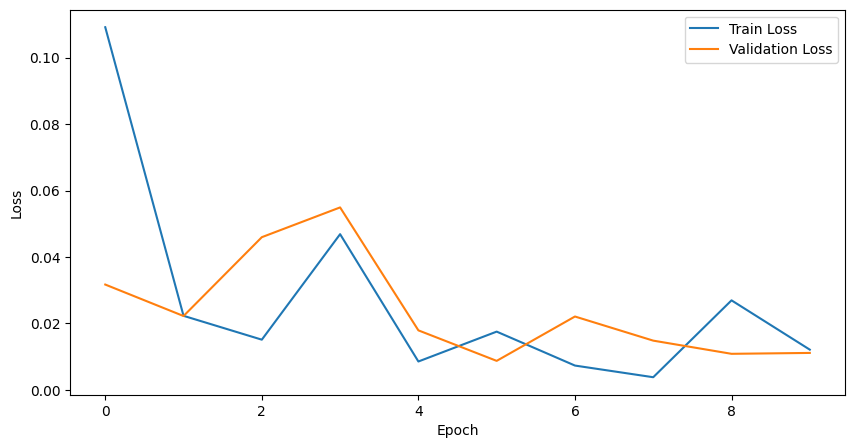

In [16]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    total_samples = 0
    for images, labels in train_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    epoch_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Skip empty batches
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total_val_samples += images.size(0)
    val_epoch_loss = val_loss / total_val_samples if total_val_samples > 0 else float('inf')
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.67%


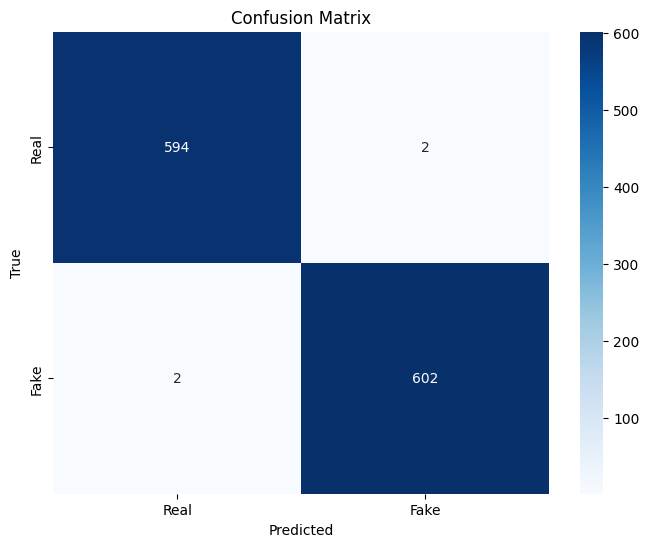

Confusion Matrix:
True Negatives (Real as Real): 594
False Positives (Real as Fake): 2
False Negatives (Fake as Real): 2
True Positives (Fake as Fake): 602


In [23]:
# Evaluate the model on the test set to compute confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float().squeeze().cpu().numpy()
        all_preds.extend(predicted)
        all_labels.extend(labels.squeeze().cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (Real as Real): {cm[0, 0]}")
print(f"False Positives (Real as Fake): {cm[0, 1]}")
print(f"False Negatives (Fake as Real): {cm[1, 0]}")
print(f"True Positives (Fake as Fake): {cm[1, 1]}")

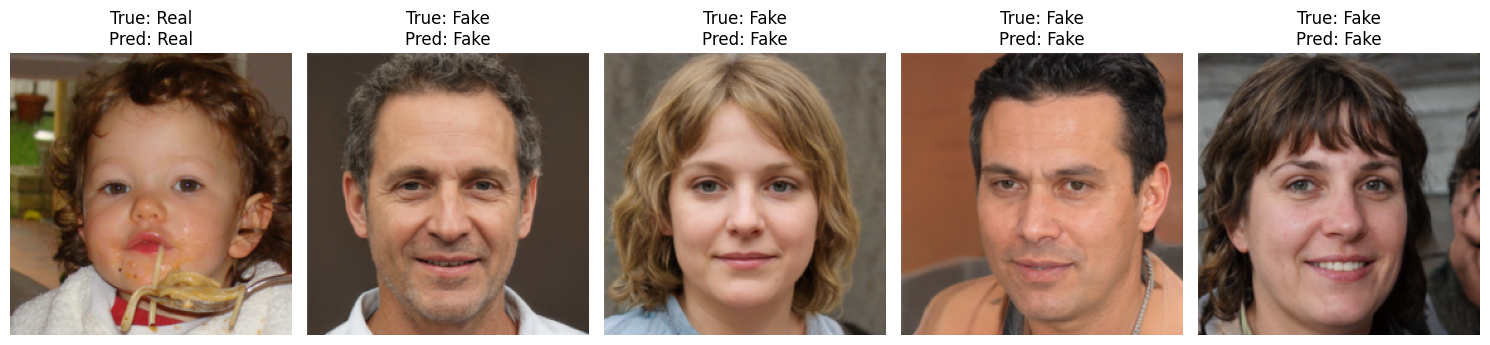

In [20]:
# Visualize predictions on 5 test images
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
with torch.no_grad():
    outputs = model(images)
    predicted = (torch.sigmoid(outputs) > 0.5).float()

# Move images to CPU for visualization
images = images.cpu()
labels = labels.cpu().squeeze()
predicted = predicted.cpu().squeeze()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {'Fake' if labels[i] else 'Real'}\nPred: {'Fake' if predicted[i] else 'Real'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/deepfake_resnet_model.pth')
print("Model saved to /content/drive/My Drive/deepfake_resnet_model.pth")

Model saved to /content/drive/My Drive/deepfake_resnet_model.pth
